In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import deque
import seaborn as sns
import random
import time
from collections import deque
from tensorflow import keras

In [10]:
def load_and_preprocess_data(file_path):
  df = pd.read_csv(file_path, parse_dates=['Date'])

  # Set the index to 'Date'
  df.set_index('Date', inplace=True)

  # Calculate returns
  df['Returns'] = df['Close'].pct_change()

  # Calculate additional features
  df['MA5'] = df['Close'].rolling(window=5).mean()
  #df['MA20'] = df['Close'].rolling(window=20).mean()
  df['Volatility'] = df['Returns'].rolling(window=5).std()

  # Normalize the data, excluding 'Returns'
  scaler = MinMaxScaler()
  columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'Volatility'] # Add MA20 Later
  df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

  # Drop rows with NaN values
  df_cleaned = df.dropna()

  return df_cleaned

# Rerun data loading with verification
# etf_data = load_and_preprocess_data(folder_path_etf)
stock_data = load_and_preprocess_data('/Users/harouneaaffoute/Downloads/Stock data/Stocks/diax.us.txt')

In [11]:
def prepare_data(df):
    df = df.sort_index()
    return df.to_dict('records')

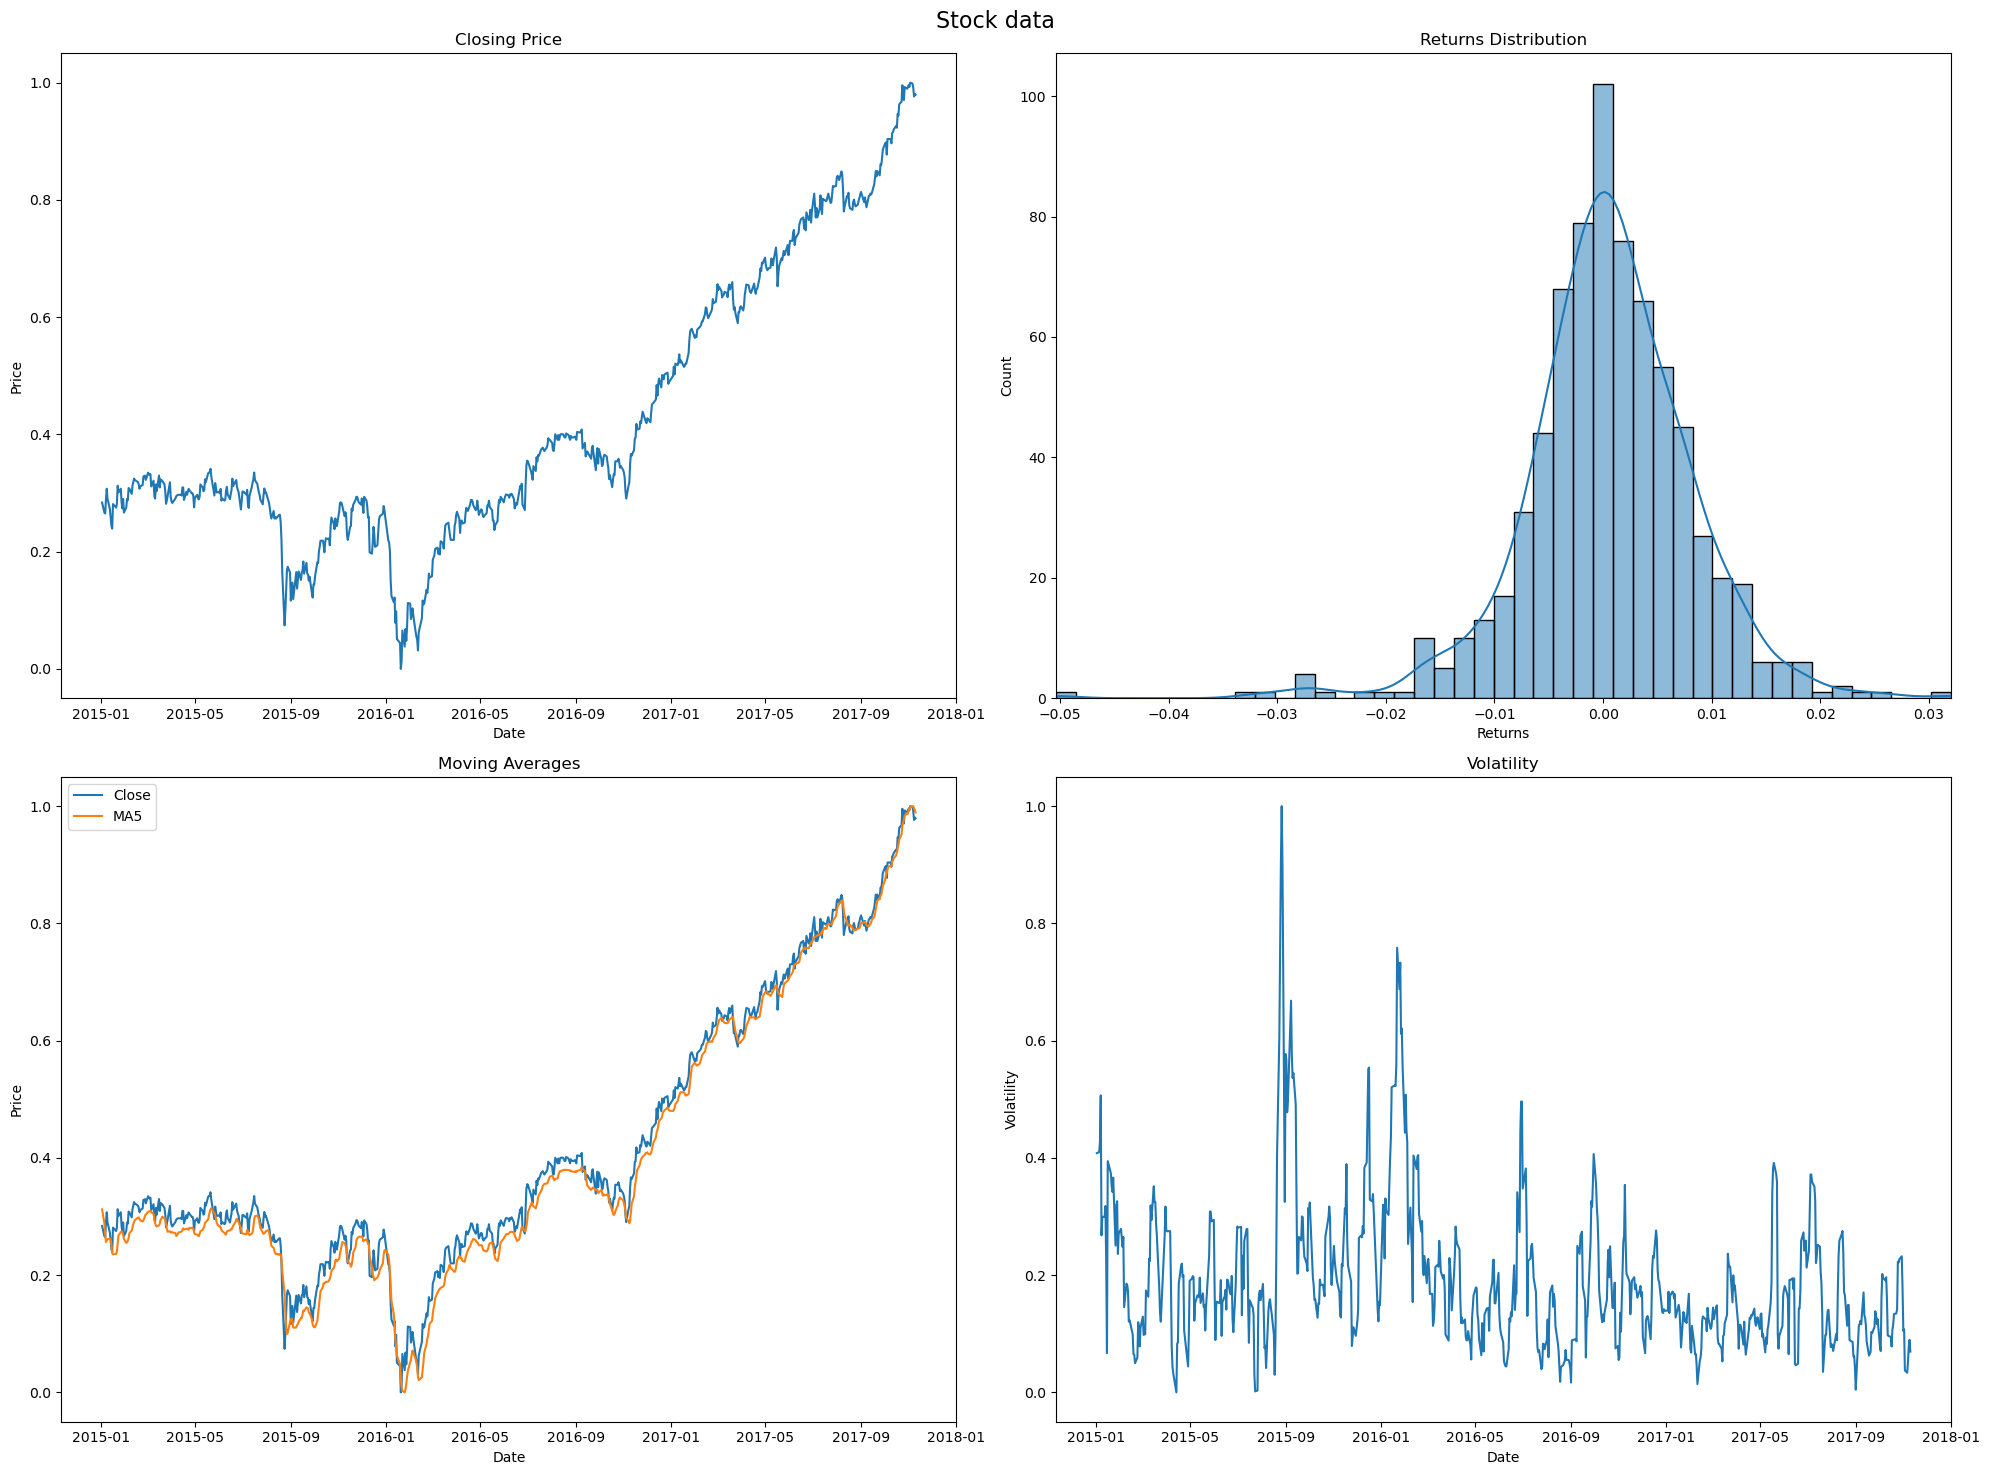

Returns summary:
count    722.000000
mean       0.000456
std        0.007728
min       -0.050339
25%       -0.003444
50%        0.000618
75%        0.004863
max        0.032016
Name: Returns, dtype: float64
Min return: -0.0503394601755256
Max return: 0.03201591751831412


In [14]:
def visualize_data(df, title):
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(f'{title}', fontsize=16)

    # Plot closing price
    axs[0, 0].plot(df.index, df['Close'])
    axs[0, 0].set_title('Closing Price')
    axs[0, 0].set_xlabel('Date')
    axs[0, 0].set_ylabel('Price')

    # Plot returns distribution
    sns.histplot(df['Returns'], kde=True, ax=axs[0, 1])
    axs[0, 1].set_title('Returns Distribution')
    axs[0, 1].set_xlabel('Returns')
    # Ensure x-axis includes negative values
    axs[0, 1].set_xlim(df['Returns'].min(), df['Returns'].max())

    # Plot moving averages
    axs[1, 0].plot(df.index, df['Close'], label='Close')
    axs[1, 0].plot(df.index, df['MA5'], label='MA5')
    #axs[1, 0].plot(df.index, df['MA20'], label='MA20')
    axs[1, 0].set_title('Moving Averages')
    axs[1, 0].set_xlabel('Date')
    axs[1, 0].set_ylabel('Price')
    axs[1, 0].legend()

    # Plot volatility
    axs[1, 1].plot(df.index, df['Volatility'])
    axs[1, 1].set_title('Volatility')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Volatility')

    plt.tight_layout()
    plt.show()

    # Print summary statistics for returns
    print(f"Returns summary:")
    print(df['Returns'].describe())
    print(f"Min return: {df['Returns'].min()}")
    print(f"Max return: {df['Returns'].max()}")

visualize_data(stock_data, 'Stock data')

In [15]:
import numpy as np
import pandas as pd

class TradingEnv:
    def __init__(self, data, initial_balance=10000, transaction_fee=0.001):
        self.data = data.iloc[-252:].reset_index(drop=True)  # Use only the last year of data and reset index
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        self.done = False
        return self._get_state()

    def step(self, action):
        if self.done:
            return self._get_state(), 0, True, {}

        current_price = self.data.loc[self.current_step, 'Close']
        reward = 0

        if action == 0:  # Buy
            if current_price > 0:
                shares_to_buy = min(self.balance // current_price, 100)  # Limit to 100 shares per transaction
                cost = shares_to_buy * current_price * (1 + self.transaction_fee)
                if cost > 0 and cost <= self.balance:
                    self.balance -= cost
                    self.position += shares_to_buy
        elif action == 1:  # Sell
            if self.position > 0:
                shares_to_sell = min(self.position, 100)  # Limit to 100 shares per transaction
                sell_value = shares_to_sell * current_price * (1 - self.transaction_fee)
                self.balance += sell_value
                self.position -= shares_to_sell
        # Action 2 is hold, so we don't need to do anything for it

        # Calculate reward based on portfolio value change
        new_portfolio_value = self.balance + self.position * current_price
        old_portfolio_value = self.balance + self.position * self.data.loc[max(0, self.current_step - 1), 'Close']
        reward = (new_portfolio_value - old_portfolio_value) / old_portfolio_value

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def _get_state(self):
        return np.array([
            self.balance / self.initial_balance,  # Normalize balance
            self.position * self.data.loc[self.current_step, 'Close'] / self.initial_balance,  # Normalize position value
            self.data.loc[self.current_step, 'Close'] / self.data.loc[0, 'Close'],  # Normalize price
            self.data.loc[self.current_step, 'Volume'] / self.data['Volume'].mean(),  # Normalize volume
            self.data.loc[self.current_step, 'Returns']
        ])

In [16]:
import numpy as np
import random
from collections import deque
from tensorflow import keras

class SimpleDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=500)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = keras.Sequential([
        keras.layers.Input(shape=(self.state_size,)),
        keras.layers.Reshape((1, self.state_size)),  # Reshape input for LSTM
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(self.action_size, activation='linear')
    ])
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filename):
        self.model.save(filename)

    @classmethod
    def load(cls, filename, state_size, action_size):
        agent = cls(state_size, action_size)
        agent.model = keras.models.load_model(filename)
        return agent

In [17]:
def train_and_evaluate(env, agent, episodes, batch_size):
    training_rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        training_rewards.append(total_reward)
        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}")

    # Final evaluation
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state

    return training_rewards, total_reward

2024-08-14 17:07:48.038384: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-14 17:07:48.038448: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-14 17:07:48.038457: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-14 17:07:48.038528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-14 17:07:48.038566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-14 17:07:49.193079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:07:49.255605:

Episode: 1/100, Total Reward: 0.01
Episode: 2/100, Total Reward: 0.03
Episode: 3/100, Total Reward: 0.00
Episode: 4/100, Total Reward: 0.02
Episode: 5/100, Total Reward: 0.03
Episode: 6/100, Total Reward: 0.01
Episode: 7/100, Total Reward: 0.01
Episode: 8/100, Total Reward: 0.01
Episode: 9/100, Total Reward: 0.02
Episode: 10/100, Total Reward: 0.02
Episode: 11/100, Total Reward: 0.02
Episode: 12/100, Total Reward: 0.05
Episode: 13/100, Total Reward: 0.07
Episode: 14/100, Total Reward: 0.03
Episode: 15/100, Total Reward: 0.05
Episode: 16/100, Total Reward: 0.03
Episode: 17/100, Total Reward: 0.02
Episode: 18/100, Total Reward: 0.02
Episode: 19/100, Total Reward: 0.02
Episode: 20/100, Total Reward: 0.03
Episode: 21/100, Total Reward: 0.09
Episode: 22/100, Total Reward: 0.04
Episode: 23/100, Total Reward: 0.03
Episode: 24/100, Total Reward: 0.09
Episode: 25/100, Total Reward: 0.04
Episode: 26/100, Total Reward: 0.02
Episode: 27/100, Total Reward: 0.01
Episode: 28/100, Total Reward: 0.00
E

/Users/harouneaaffoute/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


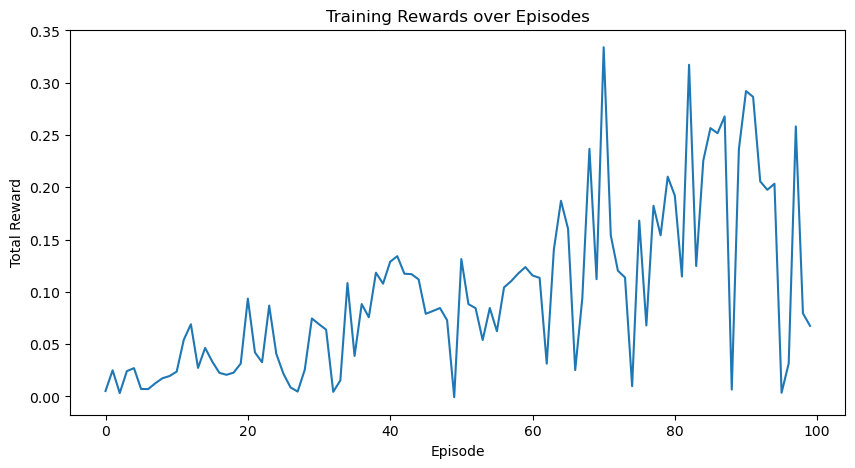

In [18]:
if __name__ == "__main__":

    env = TradingEnv(stock_data)
    state_size = 5  # Matches the number of features in _get_state
    action_size = 3  # Buy, Sell, Hold

    agent = SimpleDQNAgent(state_size, action_size)

    episodes = 100
    batch_size = 32

    training_rewards, evaluation_reward = train_and_evaluate(
        env, agent, episodes, batch_size
    )

    print(f"\nTraining completed.")
    print(f"Final evaluation reward: {evaluation_reward:.2f}")
    print(f"Average training reward: {np.mean(training_rewards):.2f}")

    # Save the trained model
    agent.save("stock_trading_model_version5.h5")

    # Optional: Plot training rewards
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(training_rewards)
    plt.title('Training Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

Now we create the same model but to handle multiple stock datas


In [19]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['Volatility'] = df['Returns'].rolling(window=5).std()
    
    scaler = MinMaxScaler()
    columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'Volatility']
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    
    return df.dropna()

def load_multiple_stocks(folder_path):
    stock_data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            stock_name = os.path.splitext(filename)[0]
            stock_data[stock_name] = load_and_preprocess_data(file_path)
    return stock_data

In [31]:
class MultiStockTradingEnv:
    def __init__(self, stock_data, initial_balance=10000, transaction_fee=0.001):
        self.stock_data = stock_data
        self.stock_names = list(stock_data.keys())
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.positions = {stock: 0 for stock in self.stock_names}
        self.current_step = 0
        self.done = False
        return self._get_state()

    def step(self, actions):
        if self.done:
            return self._get_state(), 0, True, {}

        total_reward = 0
        for i, stock in enumerate(self.stock_names):
            action = actions[i]
            current_price = self.stock_data[stock].iloc[self.current_step]['Close']
            
            if current_price > 0:  # Only proceed if the price is valid
                if action == 0:  # Buy
                    max_shares = self.balance // (current_price * (1 + self.transaction_fee))
                    shares_to_buy = min(max_shares, 100)
                    cost = shares_to_buy * current_price * (1 + self.transaction_fee)
                    if cost > 0 and cost <= self.balance:
                        self.balance -= cost
                        self.positions[stock] += shares_to_buy
                elif action == 1:  # Sell
                    shares_to_sell = min(self.positions[stock], 100)
                    sell_value = shares_to_sell * current_price * (1 - self.transaction_fee)
                    self.balance += sell_value
                    self.positions[stock] -= shares_to_sell

        # Calculate reward based on overall portfolio value change
        new_portfolio_value = self.balance + sum(self.positions[stock] * self.stock_data[stock].iloc[self.current_step]['Close'] for stock in self.stock_names)
        old_portfolio_value = self.balance + sum(self.positions[stock] * self.stock_data[stock].iloc[max(0, self.current_step - 1)]['Close'] for stock in self.stock_names)
        
        if old_portfolio_value > 0:
            total_reward = (new_portfolio_value - old_portfolio_value) / old_portfolio_value
        else:
            total_reward = 0

        self.current_step += 1
        if self.current_step >= min(len(data) for data in self.stock_data.values()) - 1:
            self.done = True

        return self._get_state(), total_reward, self.done, {}

    def _get_state(self):
        state = []
        for stock in self.stock_names:
            current_price = self.stock_data[stock].iloc[self.current_step]['Close']
            initial_price = self.stock_data[stock].iloc[0]['Close']
            volume = self.stock_data[stock].iloc[self.current_step]['Volume']
            avg_volume = self.stock_data[stock]['Volume'].mean()
            
            state.extend([
                self.balance / self.initial_balance,
                self.positions[stock] * current_price / self.initial_balance if current_price > 0 else 0,
                current_price / initial_price if initial_price > 0 else 1,
                volume / avg_volume if avg_volume > 0 else 1,
                self.stock_data[stock].iloc[self.current_step]['Returns']
            ])
        return np.array(state)

In [28]:
class MultiStockDQNAgent:
    def __init__(self, state_size, action_size, num_stocks):
        self.state_size = state_size
        self.action_size = action_size
        self.num_stocks = num_stocks
        self.memory = deque(maxlen=500)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Input(shape=(self.state_size,)),
            keras.layers.Reshape((self.num_stocks, -1)),
            keras.layers.LSTM(64, return_sequences=True),
            keras.layers.LSTM(32),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(self.num_stocks * self.action_size, activation='linear'),
            keras.layers.Reshape((self.num_stocks, self.action_size))
        ])
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return [random.randrange(self.action_size) for _ in range(self.num_stocks)]
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0], axis=1)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Predict Q-values for current states
        targets_full = self.model.predict_on_batch(states)
        
        # Predict Q-values for next states
        next_q_values = self.model.predict_on_batch(next_states)
        
        for i in range(batch_size):
            for j in range(self.num_stocks):
                if dones[i]:
                    targets_full[i, j, actions[i][j]] = rewards[i]
                else:
                    targets_full[i, j, actions[i][j]] = rewards[i] + self.gamma * np.amax(next_q_values[i, j])

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filename):
        self.model.save(filename)

    @classmethod
    def load(cls, filename, state_size, action_size, num_stocks):
        agent = cls(state_size, action_size, num_stocks)
        agent.model = keras.models.load_model(filename)
        return agent

In [29]:
def train_and_evaluate(env, agent, episodes, batch_size):
    training_rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            actions = agent.act(state)
            next_state, reward, done, _ = env.step(actions)
            total_reward += reward
            agent.remember(state, actions, reward, next_state, done)
            state = next_state
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        training_rewards.append(total_reward)
        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}")

    # Final evaluation
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        actions = agent.act(state)
        next_state, reward, done, _ = env.step(actions)
        total_reward += reward
        state = next_state

    return training_rewards, total_reward

2024-08-14 17:48:27.067217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:48:27.136096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:48:27.190348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:48:28.016420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:48:28.190822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:48:28.268819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-14 17:48:28.351094: I tensorflow/core/grappler/optimizers/cust

Episode: 1/100, Total Reward: 0.16
Episode: 2/100, Total Reward: 0.40
Episode: 3/100, Total Reward: 1.47
Episode: 4/100, Total Reward: 0.74
Episode: 5/100, Total Reward: 0.96
Episode: 6/100, Total Reward: 0.28
Episode: 7/100, Total Reward: 0.09
Episode: 8/100, Total Reward: 0.75
Episode: 9/100, Total Reward: 0.42
Episode: 10/100, Total Reward: 0.20
Episode: 11/100, Total Reward: 1.05
Episode: 12/100, Total Reward: 0.54
Episode: 13/100, Total Reward: 1.61
Episode: 14/100, Total Reward: -0.34
Episode: 15/100, Total Reward: 0.86
Episode: 16/100, Total Reward: -0.30
Episode: 17/100, Total Reward: -1.34
Episode: 18/100, Total Reward: 0.78
Episode: 19/100, Total Reward: -0.12
Episode: 20/100, Total Reward: -1.01
Episode: 21/100, Total Reward: 1.35
Episode: 22/100, Total Reward: 0.57
Episode: 23/100, Total Reward: -0.52
Episode: 24/100, Total Reward: -0.90
Episode: 25/100, Total Reward: 0.42
Episode: 26/100, Total Reward: 0.81
Episode: 27/100, Total Reward: 0.59
Episode: 28/100, Total Reward:

/Users/harouneaaffoute/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


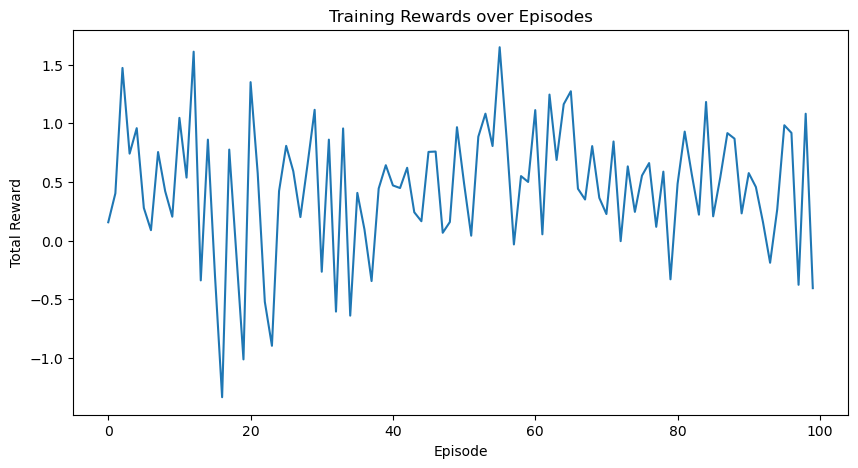

: 

In [32]:
if __name__ == "__main__":
    folder_path = '/Users/harouneaaffoute/tensorflow-test/stocks'
    stock_data = load_multiple_stocks(folder_path)

    env = MultiStockTradingEnv(stock_data)
    state_size = 5 * len(stock_data)  # 5 features per stock
    action_size = 3  # Buy, Sell, Hold
    num_stocks = len(stock_data)

    agent = MultiStockDQNAgent(state_size, action_size, num_stocks)

    episodes = 100
    batch_size = 32

    training_rewards, evaluation_reward = train_and_evaluate(env, agent, episodes, batch_size)

    print(f"\nTraining completed.")
    print(f"Final evaluation reward: {evaluation_reward:.2f}")
    print(f"Average training reward: {np.mean(training_rewards):.2f}")

    # Save the trained model
    agent.save("multi_stock_trading_model.h5")

    # Plot training rewards
    plt.figure(figsize=(10, 5))
    plt.plot(training_rewards)
    plt.title('Training Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()